<h1 align="center">Localisation optimale des capacités de production éoliennes en Europe</h1> 
<h2 align ="center"> LINMA1702 : Modèles et méthodes d'optimisation </h2>
<h3 align = "center">  Boucquey Matthieu - Chung Anthony - Lovat Louis </h3>
<h3 align= "center"> Avril 2020 </h3>

<h1> Introduction </h1>

<p>Dans le contexte de la transition énergétique, on souhaite étudier un scénario où une partie significative de la production d’électricité en Europe serait assurée par de l’<b>énergie éolienne</b>, produite sur des sites onshore ou offshore. Vu la relative instabilité de ce type de production, nous allons étudier, sous certaines hypothèses, les données à notre disposition afin d'être en mesure de déterminer parmi les sites éoliens à quels endroits et avec quelle capacité il faudrait installer des éoliennes pour obtenir la plus grande production d’énergie possible. </p>

In [7]:
import numpy as np

from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray

import matplotlib.pyplot as plt
import math 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.colors as colors
import random

colors_list = list(colors._colors_full_map.values())
random.shuffle(colors_list)

%matplotlib notebook

<h1> Partie I. Analyse d'un modèle européen intégré </h1>

Dans une première phase, nous allons chercher à <b>maximiser l’énergie totale </b>qui sera produite par les différentes installations de production d'électricité éolienne au cours d’une année. Pour ce faire, nous procédrons successivement à une clarification des données à notre disposition et des hypothèses à établir, à une modélisation linéaire du problème posé et enfin à sa résolution. Nous tâcherons également d'envisager certaines variantes et comparerons celles-ci au modèle initial.

<h2> Données et Hypothèses </h2> 

Tout d'abord, clarifions les outils mis à notre disposition et les hypothèses nécessaire à la formulation d'un modèle raisonnablement soluble. Les voici donc listés ci-après.

Données fournies :
><ul>
>    <li> 642 sites éoliens (onshore ou offshore) avec une instalation de puissance comprise entre 0 et leur capacité maximale fixée.
>    <li> Sur une année complète, le rendement heure par heure pour chacun des sites.
></ul>

<i>Nous extrayons également dans les données des éléments nécessaires, dans un second temps, à la l'implémentation du modèle.</i>

Hypothèses posées :
><ul>
>    <li> La production d'énergie supposée constante heure par heure.
>    <li> Une puissance $P$ est à installer à travers l'Europe sans distinguer les pays.
>    <li> Une fraction $\kappa$ de la puissance installable $P$ doit être de type offshore.
>    <li> La variabilité moyenne de la puissance produite est inférieure à une proportion $\delta$ de la puissance installable $P$.
>    <li> La variabilité moyenne est supposée non cyclique. <i>(En effet, les années ne se ressemble pas nécessairement)</i>
>    <li> On considère la variabilité sur des intervalles de temps de $T$ heures.    
></ul>



In [8]:
### Paramètres globaux ###

N_sites = 642            # Nombre de sites considérés
#N_heures = 24*365       # Période considérée (en [heure])
N_heures = 732

P = 500000               # Puissance à répartir parmi les sites (en [MW])
κ = 0.17                 # Proportion de la contribution des sites offshore
δ = 0.02                 # Coefficient borne la variabilité de la production d'énergie
T = 3                    # Pas de temps considéré pour la contrainte de variabilité (en [heure])

In [9]:
### Chargement et traitement des données brutes (I) : Identité des sites ###

sites = pd.read_csv('Sites.csv', index_col = "index site").sort_index()
sites_onshore = sites[sites['capacite offshore']=='Non'].copy()
sites_offshore = sites[sites['capacite offshore']=='Oui'].copy()

indice_onshore= np.array(sites_onshore.index)
indice_offshore= np.array(sites_offshore.index)

In [10]:
### Chargement et traitement des données brutes (II)  : Rendements des sites ###

rend_offshore_brut = np.genfromtxt('Rendements_offshore.csv', delimiter=',')[:,:N_heures]
rend_onshore_brut = np.genfromtxt('Rendements_onshore.csv', delimiter=',')[:,:N_heures]

rend_sites_matrix = rend_onshore_brut.copy()   
rend_sites_matrix[indice_offshore] = rend_offshore_brut[indice_offshore]

Voici par exemple les sites éoliens selon leur capacité maximale installable.

In [11]:
fig = go.Figure(data=go.Scattergeo(lon = sites['longitude'],lat = sites['latitude'], text = sites['pays'],mode = 'markers',
        marker_color = sites['couleur'], marker = dict(color = sites['couleur'], size = sites['capacites']/600)))
fig.update_layout(title = 'Sites éoliens selon leur capacité maximale installable', geo_scope = 'europe')
fig.show();

<h2> Question I.1. : Modélisation du problème d'optimisation </h2>

Attaquons nous, dès à présent, à la modélisation du problème posé précédemment. Procédons de manière succincte et structurée.

<h3> Données </h3> 

Dans un souci de clarté, posons les notations suivantes.
    
 - $ N_{s}\hspace{6px} $ : Nombre de sites sur lesquels se porte notre étude.
 - $ N_{h}\hspace{5px}$ : Période sur laquelle se porte notre étude en heure. 
 - $ \eta \hspace{20px}$ : Matrice des rendements ($ N_{s}$ X $ N_{h}$).
 - $ P \hspace{15px}$ : Puissance totale à installer en MW.
 - $ T \hspace{15px}$ : Pas de temps pour l'étude de la variabilité.
 - $ \delta \hspace{20px}$ : Ratio toléré entre deux périodes de temps T consécutives
 - $ \kappa \hspace{18px}$ : Proportion de production se faisant en site offshore.
 
<h3> Variables </h3>

Voici ensuite les variables posées.

 - $p^{i} \hspace{14px}$ : Vecteur des puissances intsallées sur chaque site.
 - $v \hspace{18px}$ : Vecteur des variables intermédiaires permettant la linéarisation des contraintes en valeur absolue.
 
<h3> Objectifs </h3>

Notre objectif est celui de la maximisation de l'énergie totale produite. La solution associée à cet objectif est équivalent à la solution qui découle d'un objectif de minimisation. 

> $\text{max } \sum_{i=1}^{N}p_{i}^{i}\sum_{j=1}^{N_{h}}\eta_{ij} \Leftrightarrow -\text{min } \sum_{i=1}^{N}p_{i}^{i}(-\sum_{j=1}^{N_{h}}\eta_{ij})$

Etant donné notre outil de résolution (la librairie CyLP), nous privilégiront la deuxième formulation.

<h3> Contraintes </h3>

<i> Contrainte 1 </i> : Capacité des sites de production.
> $ 0 \leq p^{i} \leq C_{max}^{i}  \hspace{0.8cm}
\text{ avec : } C_{max}^{i} \text{ la puissance installable maximale pour le site d'index $i$}$ 

<i> Contrainte 2 </i> : Puissance totale à installer.
> $ \sum_{j=1}^{N} p_{j}^{i} = P $

<i> Contrainte 3 </i>: Puissance à installer sur les sites offshore.
>$\sum_{j=1}^{N} \alpha_{j} p_{j}^{i} = \kappa P 
\hspace{0.8cm}
\text{ avec : }
\begin{align}
\begin{cases}
\alpha_{j} = 1 & \text{ si $j$ est l'indice d'un site offshore}\\
\alpha_{j} = 0 & \text{ si $j$ est l'indice d'un site onshore}
\end{cases}
\end{align}$

<i>Contrainte 4 </i>: Variabilité moyenne (non-cyclique) de la puissance produites sur intervalles de temps.
> $ \sum_{i=1}^{\frac{N_{h}}{T}-1} \frac{\sum_{j=1}^{N}p_{j}^{i} \big|\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}\big|}{\frac{N_{h}}{T}-1} \leq \delta P 
\begin{align} \hspace{1cm}
\Leftrightarrow \hspace{0.8cm}
\begin{cases}
    \sum_{j=1}^{N}p_{j}^{i}\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk} - l & \leq 0\\
    \sum_{j=1}^{N}p_{j}^{i}\big(-\sum_{k=Ti+1}^{Ti+T} \eta_{jk}+\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}\big) - l & \leq 0\\
    \sum_{i=1}^{\frac{N_{h}}{T}-1} l_{i} & \leq \delta P T\big(\frac{N_h}{T}-1\big)\\
\end{cases}
\end{align}$ 

<h3> Taille du modèle </h3>

Veillons maintenant à nous familiariser avec ce modèle en étudiant sa taille. En effet, la taille du modèle est un facteur non-négligeable pour l'évaluer.

<b><i>Nombre de variables</i></b> : $\mathcal{O}( N_{sites} + N_{heures}/ T )$
> Puissance installée : $N_{sites}$
>
>Variables de linéarisation : $N_{heures} / T$


<b><i>Nombre de contraintes</i></b> : $\mathcal{O}( N_{sites} + N_{heures}/ T )$
> contrainte 1 : $\hspace{0.5cm}2* N_{sites}$
>
> contrainte 2 : $\hspace{0.5cm}1$
>
> contrainte 3 : $\hspace{0.5cm}1$
>
>contrainte 4 : $\hspace{0.5cm}(2*N_{heures})/T $

On constate que le nombre de variables et de contraines évoluent conjointement. On en conclue que la taille de notre modèle varie en  $\mathcal{O}( N_{sites} + N_{heures}/ T )$.

<h2> Question I.2. Résolution numérique par la méthode du simplexe </h2>

C'est au moyen de l'alogritme du simplexe et plus spécifiquement de son implémentation pour le language python dans la librairie CyLP que nous allons résoudre le problème d'optimisation exposé plus haut.

Vous trouverez ici la fonction qui attribue la puissance à installer suivie d'une analyse et visualisation des résultats obtenus et d'une étude de la performance de notre résolution.

In [12]:
def attribution_puissance(P = 500000, κ = 0.17, δ = 0.02, T = 3):
    """ attribution_puissance est une fonction qui, à l'aide d'un algorithme du simplex 
        et de données sur des sites de production éoliens d'énergie, répartit, de manière 
        à obtenir une production d'énergie maximale, un capital de puissance à installer 
        parmi les sites disponibles.
        
        (input)
         - P [int] : Puissance à répartir parmi les sites (en [MW])
         - κ [float] : Proportion de la contribution des sites offshore 
         - δ [float] : Coefficient borne la variabilité de la production d'énergie
         - T [int] : Pas de temps considéré pour la contrainte de variabilité (en [heure])
         
        (output)
         - p_inst [numpy array] : Vecteur de dimension (N_sites, 1) reprenant les attributions
           de puissance à installer par site (en [MW])
         - E_tot [float] : Valeur maximisée de l'énergie totale produite (en [MWh])
         - status [string] : Contient l'état de la solution
         - l_sol [numpy array] : Vecteur de longueur N_heures//T-1 comprenant les bornes associées 
           à chaque valeur absolue de la variabilité
         - dual_sol [dict] : Dictionnaire ayant pour valeurs les solutions du probleme dual et
           pour clés le nom des contraintes du primal associées à celles-ci
         - dual_coutsreduits [numpy array] : Vecteur de taille N_sites reprenant les coûts réduits 
           du problème dual
    """
    
    ## Création object CyClpSimplex ##
    s = CyClpSimplex()
    
    ## Ajout des variables ##
    puiss = s.addVariable('Puissance installee', N_sites) 
    L = s.addVariable('l', N_heures//T -1) 
    
    ## Fonction objectif ##
    rend_somme = rend_sites_matrix.sum(axis = 1)
    s.objective = CyLPArray(-rend_somme)*puiss
    
    ## Ajout des contraintes ##
    
    #~ Contrainte 1 : Capacité des sites de production ~#
    sites_capacite_max = CyLPArray(sites["capacites"])
    s.addConstraint(0 <= puiss <= sites_capacite_max, "Contrainte capacite max")
    
    #~ Contrainte 2 : Puissance totale à installer ~#
    s.addConstraint(puiss.sum() == P,"Puissance à installer")
    
    #~ Contrainte 3 : Puissance à installer sur les sites offshore ~#
    s.addConstraint(puiss[indice_offshore].sum() - κ*puiss.sum() == 0,"Puissance offshore à installer")
     
    #~ Contrainte 4 : Variabilité moyenne (non-cyclique) de la puissance produites sur intervalles de temps ~#
    rend_sites_par_intervalle = np.sum(rend_sites_matrix.reshape(N_sites, N_heures//T, T), axis = 2)
    diff_rend = np.asmatrix(rend_sites_par_intervalle[:,1:] - rend_sites_par_intervalle[:,:-1]).T
    
    s.addConstraint(L.sum() <= δ*P*(N_heures//T-1)*T,"Variabilité")
    s.addConstraint(diff_rend*puiss - L <= 0, "Abs contrainte 1")
    s.addConstraint(-diff_rend*puiss - L <= 0, "Abs contrainte 2")
    
    ## Résolution problème d'optimisation via l'algorithme du simplexe ##
    s.primal()    
    
    ## Valeur à retourner ##
    p_inst = s.primalVariableSolution['Puissance installee']
    E_tot = -s.objectiveValue
    status_sol = s.getStatusString()
    l_sol = s.primalVariableSolution['l']
    dual_sol = s.dualConstraintSolution
    dual_coutsreduits = s.dualVariableSolution['Puissance installee']
    
    return p_inst, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits

In [16]:
P = 500000
κ = 0.17
δ = 0.02
T = 3

p_inst, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits = attribution_puissance(P,κ,δ,T)

var = np.sum(l_sol)*T//(N_heures)
rend_moyen = E_tot/(N_heures*P)
resultat = np.array([[status_sol], [np.round(E_tot)], [np.round(p_inst.sum())], [np.round(p_inst[indice_offshore].sum())],
                     [round(var)], [np.round(rend_moyen,4)]])
result_df = pd.DataFrame(resultat,index = ["Etat de la solution","Energie totale [MWh]","Somme puissances installées [MW]",
                                           "Somme puissances installées (offshore) [MW]","Variabilité moyenne [MWh]",
                                           "Rendement moyen de sites [-]"], columns=["Résultat obtenu (arrondi)"])
result_df.index.name = "Résultat"
result_df.head(6)

,Résultat obtenu (arrondi)
Résultat,
Etat de la solution,optimal
Energie totale [MWh],192644544.0
Somme puissances installées [MW],500000.0
Somme puissances installées (offshore) [MW],85000.0
Variabilité moyenne [MWh],29877.0
Rendement moyen de sites [-],0.5264


In [14]:
carte_p_inst_w_zero = sites.copy()

carte_p_inst_w_zero['puissance installee'] = p_inst
carte_p_inst = carte_p_inst_w_zero[carte_p_inst_w_zero['puissance installee']!=0]

fig = go.Figure(data=go.Scattergeo(
        lon = carte_p_inst['longitude'],
        lat = carte_p_inst['latitude'],
        text = carte_p_inst['pays'],
        mode = 'markers',
        marker=dict(
        color = "#7b0323",
        size = carte_p_inst["puissance installee"]*0.002)
        ))

fig.update_layout(
        title = 'Puissance installée et leurs importances',
        geo_scope = 'europe'
    )
fig.show();

In [9]:
carte_p_inst.describe()

,latitude,longitude,scores,capacites,puissance installee
count,264.000000,264.000000,264.000000,264.000000,264.000000
mean,54.022727,7.481061,0.002576,1900.373819,1893.939394
std,9.545143,9.486413,0.001536,2250.347731,2249.016911
min,37.000000,-10.000000,0.001031,76.872180,73.107099
25%,46.750000,-1.000000,0.001701,498.085669,498.085669
50%,54.000000,8.000000,0.002205,1056.793746,1056.793746
75%,62.000000,15.000000,0.002895,2832.910695,2815.650324
max,71.000000,31.000000,0.010571,15478.589744,15478.589744


In [10]:
#TODO variabilité des best sites (Est -ce que les best sites sont compatible savec la notion de variabilité 
#     ou alor est-ce qu'ils sont tres tres bons sur toutes l'année mais produisent beaucoup de maniere tres instable )

dico = {}
for i in range(len(rend_sites_matrix)):
    dico[i] = rend_sites_matrix[i].sum()

dict_sorted = sorted(dico.items(), key=lambda x: x[1],reverse=True)
dict_best = dict_sorted[:10]

index_best = np.zeros(10)
rendement_best = np.zeros(10)
for i in range(10):
    index_best[i] = dict_best[i][0]
    rendement_best[i]=(dict_best[i][1])/N_heures

classement = pd.DataFrame([],columns = sites.columns)

for i in range(10):
    ligne = sites[sites.index==index_best[i]]
    classement= classement.append(ligne)
del classement["couleur"]
del classement["scores"]
del classement["capacites"]
classement.index.name = "index site"
classement["η"] = rendement_best
classement["η - η_moy"] = rendement_best - rend_moyen


In [11]:
# Classement des meilleurs sites suivant leur rendement moyen
print("Classement des meilleurs sites suivant leur rendement moyen")
classement.head(10)

Classement des meilleurs sites suivant leur rendement moyen


,latitude,longitude,pays,capacite offshore,η,η - η_moy
index site,,,,,,
67,57.0,6.0,Danemark,Oui,0.705639,0.179287
68,57.0,7.0,Danemark,Oui,0.693775,0.167424
69,57.0,8.0,Danemark,Non,0.685381,0.159030
2,54.0,9.0,Allemagne,Non,0.671455,0.145104
408,57.0,5.0,Norvège,Oui,0.662672,0.136321
75,56.0,8.0,Danemark,Non,0.661150,0.134799
399,58.0,6.0,Norvège,Oui,0.657555,0.131203
73,56.0,6.0,Danemark,Oui,0.655823,0.129472
74,56.0,7.0,Danemark,Oui,0.655724,0.129373


In [12]:
# Visualisations des données pour les sites 

fig = go.Figure(data=go.Scattergeo(
        lon = classement['longitude'],
        lat = classement['latitude'],
        text = classement['pays'],
        mode = 'markers',
        marker=dict(
        color = "#7b0323",
        size = classement['η']*np.linspace(3,1,10)*20)
        ))

fig.update_layout(
        title = 'Les dix sites avec les meilleurs rendements moyens',
        geo_scope = 'europe'
    )
fig.show();

# Question I.3. 

### a)

Dans ce point, nous allons étudier l'impact d'une faible variation $\Delta P$ de la contrainte :
$$ \sum_{i=1}^{N_{sites}}p_{i}^{installée} = P$$
qui deviendra : 
$$ \sum_{i=1}^{N_{sites}}p_{i}^{installée} = P + \Delta P$$
sur le résultat $z$ de notre maximisation : 
$$ \text{max } \sum_{j=1}^{N_{heures}}\sum_{i=1}^{N_{sites}} \eta_{ij}p_{i}^{installée}$$

Notre modélisation pouvant se rapporter à un modèle du type:
$$
\text{min } c^{T}x \\
Ax \geq b \\
x \geq 0
$$

Nous pouvons facilement conclure que cette variation $\Delta P$ correspond en fait à une variation $\Delta b$ de notre vecteur contrainte.

Nous pouvons observer que sous la condition $\Delta b << b$ il est possible de réécrire le résultat de notre maximisation comme étant :
$$ z + \Delta z\\
\text{Avec}\\
\Delta z = y_{*}^{T} \Delta b\\
\text{Où $y_{*}$ est la solution de notre problème dual.}
$$
\
notre vecteur $b$ étant de la forme :
$$ b =
\begin{pmatrix}
0\\
.\\
.\\
0\\
\Delta P \\
0\\
.\\
.\\
0
\end{pmatrix}
$$
Il suffit que notre programme aille chercher la composante appropriée de $y_{*}$ et la multiplie par $\Delta P$ pour obtenir notre variation $\Delta z$

### b) 
TODO : A rédiger, mais les dix meilleurs sites sont bien ceux avec les meilleurs rendements moyen sur l'année

Notre modélisation pouvant se rapporter à un modèle du type:
$$
\text{min } c^{T}x \\
Ax \geq b \\
x \geq 0
$$

Le problème dual associé peut s'écrire sous la forme :
$$
\text{max } b^{T}y \\
A^{T}y \leq c\\
y \geq 0\\
$$

Ainsi, nous pouvons déduire que les plus grandes composantes de notre vecteur contrainte $b$ auront un impact plus marqué sur le résultat du dual. Nous cherchons donc dans notre programme les dix plus grandes composantes de $b$ qui s'avèrent également être les dix meilleurs sites du point de vue de la rentabilité.

$\it{\text{( Voir "Analyse du dual" pour les résultats du a) et b) )}}$

### Analyse du dual

In [13]:
result = {}
for i in range(len(dual_coutsreduits)):
    result[i]=dual_coutsreduits[i]
result_sorted = sorted(result.items(), key=lambda x: x[1],reverse=True)

array_capacite = np.zeros((10,2))
                          
for i in range(10):
    array_capacite[i][0] = int(result_sorted[i][0])
    array_capacite[i][1] = result_sorted[i][1]
array_capacite_df = pd.DataFrame (array_capacite,columns = ["index site","coûts réduits du dual"])

print("I.3.a) Solution du problème dual associée à la contrainte de la puissance P: ", dual_sol["Puissance à installer"][0])

print("I.3.b) Classement des dix sites pour lesquels une augmentation de leur capacité maximale serait la plus rentable \n       en termes d'énergie produite")
array_capacite_df.head(10)

I.3.a) Solution du problème dual associée à la contrainte de la puissance P:  -313.35845762715627
I.3.b) Classement des dix sites pour lesquels une augmentation de leur capacité maximale serait la plus rentable 
       en termes d'énergie produite


,index site,coûts réduits du dual
0,143.0,340.151948
1,261.0,332.258664
2,266.0,323.015672
3,255.0,308.223188
4,144.0,302.514003
5,257.0,235.369744
6,59.0,233.350180
7,258.0,222.714262
8,60.0,212.928889
9,377.0,211.199035


# Question I.4.

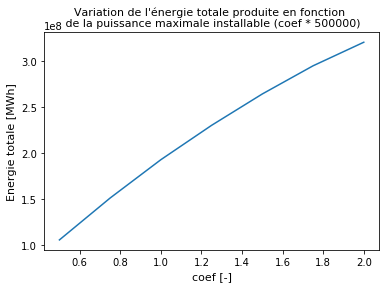

In [14]:
steps = 7
coef = np.linspace(0.5,2,steps)
puiss = np.zeros(steps)
for i in range (steps):
    puiss[i] = attribution_puissance(500000*coef[i])[1]

plt.plot(coef, puiss)
plt.title("Variation de l'énergie totale produite en fonction \n de la puissance maximale installable (coef * 500000)", fontsize=11)
plt.xlabel("coef [-]", fontsize=11)
plt.ylabel("Energie totale [MWh]", fontsize=11)

plt.show()

# Question I.5. a)

Admettons que nous n'imposions plus la contrainte :

$ \sum_{i=1}^{N_{sites}} p_{i}^{installées} = P $

Mais que nous la remplacions par :

$ \sum_{i=1}^{N_{sites}} p_{i}^{installées} \leq P $

Nous pourrions nous attendre à obtenir une solution au moins aussi bonne que dans notre cas d'origine. En effet, la contrainte d'égalité stricte étant plus forte, nous procéderions en fait à une relaxation de notre problème, or, la solution d'un problème relaxé est toujours au moins aussi bonne que celle de son problème d'origine.

Aussi, c'est ce que vérifie notre bout de code ci-dessous.

In [17]:
#TODO contraince active, variable =0

def attribution_puissance_variante1(P = 500000, κ = 0.17, δ = 0.02, T = 3):
    """ attribution_puissance est une fonction qui, à l'aide d'un algorithme du simplex 
        et de données sur des sites de production éoliens d'énergie, répartit, de manière 
        à obtenir une production d'énergie maximale, un capital de puissance à installer 
        parmi les sites disponibles.
        
        (input)
         - P [int] : Puissance à répartir parmi les sites (en [MW])
         - κ [float] : Proportion de la contribution des sites offshore 
         - δ [float] : Coefficient borne la variabilité de la production d'énergie
         - T [int] : Pas de temps considéré pour la contrainte de variabilité (en [heure])
         
        (output)
         - p_inst [numpy array] : Vecteur de dimension (N_sites, 1) reprenant les attributions
           de puissance à installer par site (en [MW])
         - E_tot [float] : Valeur maximisée de l'énergie totale produite (en [MWh])
         - status [string] : Contient l'état de la solution
         - l_sol [numpy array] : Vecteur de longueur N_heures//T-1 comprenant les bornes associées 
           à chaque valeur absolue de la variabilité
         - dual_sol [dict] : Dictionnaire ayant pour valeurs les solutions du probleme dual et
           pour clés le nom des contraintes du primal associées à celles-ci
         - dual_coutsreduits [numpy array] : Vecteur de taille N_sites reprenant les coûts réduits 
           du problème dual
    """
    
    ## Création object CyClpSimplex ##
    s = CyClpSimplex()
    
    ## Ajout des variables ##
    puiss = s.addVariable('Puissance installee', N_sites) 
    L = s.addVariable('l', N_heures//T -1) 
    
    ## Fonction objectif ##
    rend_somme = rend_sites_matrix.sum(axis = 1)
    s.objective = CyLPArray(-rend_somme)*puiss
    
    ## Ajout des contraintes##
    
    #~ Contrainte 1 : Capacité des sites de production ~#
    sites_capacite_max = CyLPArray(sites["capacites"])
    s.addConstraint(0 <= puiss <= sites_capacite_max, "Contrainte capacite max")
    
    #~ Contrainte 2 : Puissance à installer ~#
    s.addConstraint(puiss.sum() <= P,"Puissance à installer")
    
    #~ Contrainte 3 : Puissance à installer sur les sites offshore ~#
    s.addConstraint(puiss[indice_offshore].sum() - κ*puiss.sum() == 0,"Puissance offshore à installer")
     
    #~ Contrainte 4 : Variabilité moyenne (non-cyclique) de la puissance produites sur intervalles de temps ~#
    s.addConstraint(L.sum() <= δ*P*(N_heures//T-1)*T,"Variabilité")
    
    rend_sites_par_intervalle = np.sum(rend_sites_matrix.reshape(N_sites, N_heures//T, T), axis = 2)
    diff_rend = np.asmatrix(rend_sites_par_intervalle[:,1:] - rend_sites_par_intervalle[:,:-1]).T
    
    s.addConstraint(diff_rend*puiss - L <= 0, "Abs contrainte 1")
    s.addConstraint(-diff_rend*puiss - L <= 0, "Abs contrainte 2")
    
    ## Résolution problème d'optimisation via l'algorithme du simplexe ##
    s.primal()    
    
    ## Valeur à retourner ##
    p_inst = s.primalVariableSolution['Puissance installee']
    E_tot = -s.objectiveValue
    status_sol = s.getStatusString()
    l_sol = s.primalVariableSolution['l']
    dual_sol = s.dualConstraintSolution
    dual_coutsreduits = s.dualVariableSolution['Puissance installee']
    
    return p_inst, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits


In [28]:
P = 500000
κ = 0.17
δ = 0.02
T =3

p_inst_1, E_tot_1, status_sol_1, l_sol_1, dual_sol_1, dual_coutsreduits_1 = attribution_puissance_variante1(P,κ,δ,T)
p_inst, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits = attribution_puissance(P,κ,δ,T)

var_1 = np.sum(l_sol_1)*T//(N_heures)
var = np.sum(l_sol)*T//(N_heures)

resultat_1 = np.array([[status_sol_1,status_sol],
                        [E_tot_1, E_tot],
                        [np.round(p_inst_1.sum()),np.round(p_inst.sum())],
                        [np.round(p_inst_1[indice_offshore].sum()),np.round(p_inst[indice_offshore].sum())],
                        [round(var_1),round(var)],
                        [" "," "]])
result_1_df = pd.DataFrame(resultat,
                           index = ["Etat de la solution",
                                    "Energie totale [MWh]",
                                    "Somme des puissances installées [MW]",
                                    "Somme des puissances installées (offshore) [MW]",
                                    "Variabilité moyenne [MWh]",
                                    " "],
                           columns=["Résultat de la variante 1 (arrondi)",
                                    "Résultat initial (arrondi)"])
result_1_df.index.name = "Résultat"


print("\nChangement de: ", (E_tot_1/E_tot)*100 -100 ,"% par rapport au problème initial")
result_1_df.head(5)


Changement de:  2.842170943040401e-14 % par rapport au problème initial


,Résultat de la variante 1 (arrondi),Résultat initial (arrondi)
Résultat,,
Etat de la solution,optimal,-
Energie totale [MWh],192644544.0,192644543
Somme des puissances installées [MW],500000.0,500000
Somme des puissances installées (offshore) [MW],85000.0,85000
Variabilité moyenne [MWh],29877.0,30000.0


# Question I.5. b)

Considérons maintenant que nous n'imposons plus sur notre problème initial la contrainte :

$
\sum_{i=1}^{\frac{N_{heures}}{T}-1} \frac{\sum_{j=1}^{N}p_{j}^{installée}|\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}|}{\frac{N_{heures}}{T}-1} \leq \delta P
$

Mais que nous la remplaçons par la nouvelle contrainte :

$
\text{max } ( \sum_{j=1}^{N}p_{j}^{installée}|\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}| , i \in [1,\frac{N_{heures}}{T}-1] ) \leq \delta P
$

A l'inverse du point précédent, cette nouvelle contrainte est plus forte que celle d'origine, le problème est donc plus contraint que précédemment et nous nous attendons à ce que notre solution s'en trouve diminuée.

Aussi, c'est ce que confirme notre bout de code ci-dessous.

In [34]:
#TODO contraince active, variable =0

def attribution_puissance_variante2(P = 500000, κ = 0.17, δ = 0.02, T = 3):
    """ attribution_puissance est une fonction qui, à l'aide d'un algorithme du simplex 
        et de données sur des sites de production éoliens d'énergie, répartit, de manière 
        à obtenir une production d'énergie maximale, un capital de puissance à installer 
        parmi les sites disponibles.
        
        (input)
         - P [int] : Puissance à répartir parmi les sites (en [MW])
         - κ [float] : Proportion de la contribution des sites offshore 
         - δ [float] : Coefficient borne la variabilité de la production d'énergie
         - T [int] : Pas de temps considéré pour la contrainte de variabilité (en [heure])
         
        (output)
         - p_inst [numpy array] : Vecteur de dimension (N_sites, 1) reprenant les attributions
           de puissance à installer par site (en [MW])
         - E_tot [float] : Valeur maximisée de l'énergie totale produite (en [MWh])
         - status [string] : Contient l'état de la solution
         - l_sol [numpy array] : Vecteur de longueur N_heures//T-1 comprenant les bornes associées 
           à chaque valeur absolue de la variabilité
         - dual_sol [dict] : Dictionnaire ayant pour valeurs les solutions du probleme dual et
           pour clés le nom des contraintes du primal associées à celles-ci
         - dual_coutsreduits [numpy array] : Vecteur de taille N_sites reprenant les coûts réduits 
           du problème dual
    """
    
    ## Création object CyClpSimplex ##
    s = CyClpSimplex()
    
    ## Ajout des variables ##
    puiss = s.addVariable('Puissance installee', N_sites) 
    L = s.addVariable('l', N_heures//T -1) 
    
    ## Fonction objectif ##
    rend_somme = rend_sites_matrix.sum(axis = 1)
    s.objective = CyLPArray(-rend_somme)*puiss
    
    ## Ajout des contraintes##
    
    #~ Contrainte 1 : Capacité des sites de production ~#
    sites_capacite_max = CyLPArray(sites["capacites"])
    s.addConstraint(0 <= puiss <= sites_capacite_max, "Contrainte capacite max")
    
    #~ Contrainte 2 : Puissance à installer ~#
    s.addConstraint(puiss.sum() == P,"Puissance à installer")
    
    #~ Contrainte 3 : Puissance à installer sur les sites offshore ~#
    s.addConstraint(puiss[indice_offshore].sum() - κ*puiss.sum() == 0,"Puissance offshore à installer")
     
    #~ Contrainte 4 : Variabilité moyenne (non-cyclique) de la puissance produites sur intervalles de temps ~#
    s.addConstraint(np.array(L).max() <= δ*P*(N_heures//T-1)*T,"Variabilité")
    
    rend_sites_par_intervalle = np.sum(rend_sites_matrix.reshape(N_sites, N_heures//T, T), axis = 2)
    diff_rend = np.asmatrix(rend_sites_par_intervalle[:,1:] - rend_sites_par_intervalle[:,:-1]).T
    
    s.addConstraint(diff_rend*puiss - L <= 0, "Abs contrainte 1")
    s.addConstraint(-diff_rend*puiss - L <= 0, "Abs contrainte 2")
    
    ## Résolution problème d'optimisation via l'algorithme du simplexe ##
    s.primal()    
    
    ## Valeur à retourner ##
    p_inst = s.primalVariableSolution['Puissance installee']
    E_tot = -s.objectiveValue
    status_sol = s.getStatusString()
    l_sol = s.primalVariableSolution['l']
    dual_sol = s.dualConstraintSolution
    dual_coutsreduits = s.dualVariableSolution['Puissance installee']
    
    return p_inst, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits


In [36]:
def attribution_puissance_variante2(P = 500000, kappa = 0.17, delta = 0.02, T = 3):
    s = CyClpSimplex()
    
    # Add variables
    x = s.addVariable('x', N_sites)
    
    # Add constraints
    p_max = CyLPArray(sites["capacites"])
    s += 0 <= x <= p_max
    
    s.addConstraint(x.sum() == P,"contrainte puissance max")
    
    offshorearray = np.zeros(N_sites)
    offshorearray[indice_offshore] = 1             # set à 1 les sites offshore
    s.addConstraint((CyLPArray(offshorearray)*x) == kappa*P,"contrainte offshore")
    
    n_interval = N_heures//T  # nombre d'intervalle sur les heures imparties
    L = s.addVariable('l', n_interval-1) # vecteur L de longeur n_interval pour gérer valeurs absolues 
    
    sum = np.sum(rend_sites_matrix.copy().reshape(N_sites, n_interval, T), axis = 2)
    sum_shifted = sum.copy()
    sum_shifted = np.roll(sum, 1, axis = 1)
    sum = np.delete(sum, np.s_[0],  1)
    sum_shifted = np.delete(sum_shifted, np.s_[0],  1)
    diff = CyLPArray((sum_shifted - sum).transpose())
    s += diff*x - L <= 0
    s += -diff*x - L <= 0
    s.addConstraint(np.array(L).max() <= delta*P,"variabilité")  # contrainte de variabilité
    
    #print ("\nConstraints :\n", s.constraints)
    #print ("\nConstraintMatrix :\n", s.coefMatrix)
    
    # Set the objective function
    c = -CyLPArray(np.sum(rend_sites_matrix, axis = 1))
    
    s.objective = c * x
    #print("\nc = ",s.objective)
    
    # Solve using primal Simplex
    s.primal()
    
    dual_variable = s.dualVariableSolution["x"]

    dual_constraint = s.dualConstraintSolution
    
    
    # Return values
    return s.primalVariableSolution['x'], -s.objectiveValue, s.getStatusString(), s.primalVariableSolution['l'],dual_constraint,dual_variable
    
## Solutions ##

PUISSANCE_INSTALLEE2, ENERGIE_TOTALE2, type_sol2, l_sol2,dual_constraint2,dual_variable2 = attribution_puissance_variante2(500000,0.17,0.02,3)

#print ("\nlsol = ",l_sol2) 
#print ("\nPuissance installée2 = ",PUISSANCE_INSTALLEE2) 
print("\nEnergie totale2 = ", ENERGIE_TOTALE2, "MWh") #192644543.2528026
#print("\nEtat de la solution2 ? = ", type_sol2)

print("\nEnergie totale = ", E_tot, "MWh")

print("\nDiminution de: ", (ENERGIE_TOTALE2/E_tot)*100 -100 ,"% par rapport au problème initial")


Energie totale2 =  84229021.81038766 MWh

Energie totale =  192644543.84691712 MWh

Diminution de:  -56.27749422411915 % par rapport au problème initial


# Question I.5. c)

In [ ]:
#TODO contraince active, variable =0

def attribution_puissance_variante3(P = 500000, κ = 0.17, δ = 0.02, T = 3):
    """ attribution_puissance est une fonction qui, à l'aide d'un algorithme du simplex 
        et de données sur des sites de production éoliens d'énergie, répartit, de manière 
        à obtenir une production d'énergie maximale, un capital de puissance à installer 
        parmi les sites disponibles.
        
        (input)
         - P [int] : Puissance à répartir parmi les sites (en [MWh])
         - kappa [float] : Proportion de la contribution des sites offshore 
         - delta [float] : Coefficient borne la variabilité de la production d'énergie
         - T [int] : Pas de temps considéré pour la contrainte de variabilité (en [heure])
         
        (output)
         - p_inst [numpy array] : Vecteur de dimension (N_sites, 1) reprenant les attributions
           de puissance à installer par site
         - E_tot [float] : Valeur maximisée de l'énergie totale produite (en [MWh])
         - status [string] : Contient l'état de la solution
         - l_sol [numpy array] : Vecteur de longueur N_heures//T-1 comprenant les bornes associées 
           à chaque valeur absolue de la variabilité
         - dual_sol [dict] : Dictionnaire ayant pour valeurs les solutions du probleme dual et
           pour clés le nom des contraintes du primal associées à celles-ci
         - dual_coutsreduits [numpy array] : Vecteur de taille N_sites reprenant les coûts réduits 
           du problème dual
    """
    
    ## Création object CyClpSimplex ##
    s = CyClpSimplex()
    
    ## Ajout des variables ##
    puiss = s.addVariable('Puissance installee', N_sites)
    prod_heure = s.addVariable('Production par heure', N_heures)
    L = s.addVariable('l', N_heures-1) 
    
    ## Fonction objectif ##
    s.objective = CyLPArray(-1*np.ones(N_heures))*prod_heure
    
    ## Ajout des contraintes##
    
    #~ Contrainte 1 : Capacité des sites de production ~#
    sites_capacite_max = CyLPArray(sites["capacites"])
    s.addConstraint(0 <= puiss <= sites_capacite_max, "Contrainte capacite max")
    
    #~ Contrainte 2 : Puissance à installer ~#
    s.addConstraint(puiss.sum() == P,"Puissance à installer")
    
    #~ Contrainte 3 : Puissance à installer sur les sites offshore ~#
    s.addConstraint(puiss[indice_offshore].sum() - κ*puiss.sum() == 0,"Puissance offshore à installer")
    
    #~ Contrainte 4 : Borne sur la production horaire ~#
    s.addConstraint(prod_heure >= 0, "Positivité prod_heure")
    s.addConstraint(prod_heure - CyLPArray(rend_sites_matrix.T)*puiss <= 0, "Borne sur la production horaire")
    
     
    #~ Contrainte 5 : Variabilité moyenne (non-cyclique) de la puissance produites sur intervalles de temps ~#
    s.addConstraint(L.sum() <= δ*P*(N_heures-1),"Variabilité")
    
    
    """rend_sites_par_intervalle = np.sum(rend_sites_matrix.reshape(N_sites, N_heures//T, T), axis = 2)
    diff_rend = np.asmatrix(rend_sites_par_intervalle[:,1:] - rend_sites_par_intervalle[:,:-1]).T
    
    s.addConstraint(diff_rend*puiss - L <= 0, "Abs contrainte 1")
    s.addConstraint(-diff_rend*puiss - L <= 0, "Abs contrainte 2")"""
    """
    for i in range(N_heures//T-1):
        s.addConstraint(prod_heure[T*(i+1):T*(i+2)].sum() - prod_heure[T*i:T*(i+1)].sum() - L[i] <= 0, "Abs contrainte " +str(i))
        s.addConstraint(-prod_heure[T*(i+1):T*(i+2)].sum() + prod_heure[T*i:T*(i+1)].sum() - L[i] <= 0, "Abs contrainte "+str(i)+"bis")
    """
    
    s.addConstraint(prod_heure[0:N_heures-1] - prod_heure[1:N_heures] - L <= 0, "Abs contrainte ")
    s.addConstraint(-prod_heure[0:N_heures-1] + prod_heure[1:N_heures] - L <= 0, "Abs contrainte bis ")
    
    """#~ Contrainte 4bis : Variabilité moyenne (cyclique) de la puissance produites sur intervalles de temps ~#
    s.addConstraint( L.sum() <= δ*P*(N_heures//T)*T,"Variabilité")
    
    rend_sites_par_intervalle = rend_sites_matrix.reshape(N_sites, N_heures//T, T).sum(axis = 2).T
    rend_sites_par_intervalle_decalle = np.roll(rend_sites_par_intervalle.copy(), 1, axis = 1)
    diff_puiss = np.asmatrix(rend_sites_par_intervalle_decalle - rend_sites_par_intervalle)*puiss

    s.addConstraint(0 <= L - diff_puiss, "Abs contrainte 1")
    s.addConstraint(0 <= L + diff_puiss, "Abs contrainte 2")"""
    
    ## Résolution problème d'optimisation via l'algorithme du simplexe ##
    s.primal()
    
    ## Valeur à retourner ##
    p_inst = s.primalVariableSolution['Puissance installee']
    prod_horaire = s.primalVariableSolution['Production par heure']
    E_tot = -s.objectiveValue
    status_sol = s.getStatusString()
    l_sol = s.primalVariableSolution['l']
    dual_sol = s.dualConstraintSolution
    dual_coutsreduits = s.dualVariableSolution['Puissance installee']
    
    return p_inst, prod_horaire, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits

In [ ]:

P = 500000
κ = 0.17
δ = 0.02 #La contrainte de variabilité n'est plus prise en compte à partir d'une valeur comprise entre 0.009 et 0.0095
T=3

p_inst, prod_horaire, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits = attribution_puissance_variante3(P,κ,δ,T)


#print ("\nPuissance installée = ",p_inst) 
print("\nEnergie totale = ",  E_tot, "MWh")
print("\nEtat de la solution ? = ", status_sol)

print("\n production horaire : ", prod_horaire, "\n")

print("Vérifications : ")
print("Somme des puissances installées = ", p_inst.sum())
print("Somme des puissances installées (offshore) = ", p_inst[indice_offshore].sum())

var = np.sum(l_sol)
print("Variabilité obtenue : ", var," ?= ", δ*P*(N_heures-1), " : Variabilité théorique")

rend_moyen = E_tot/(N_heures*P)
print("Rendement moyen de l'ensemble des sites sur la période considérée :", rend_moyen )
